In [31]:
import pandas as pd
import re
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
# Load raw data
df2014 = pd.read_csv('data/2014_Financial_Data.csv')
df2015 = pd.read_csv('data/2015_Financial_Data.csv')
df2016 = pd.read_csv('data/2016_Financial_Data.csv')
df2017 = pd.read_csv('data/2017_Financial_Data.csv')
df2018 = pd.read_csv('data/2018_Financial_Data.csv')

In [3]:
# Inspect how does it look like -- 
# The "Unnamed: 0" column is probably stock ticker
df2014.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,shortTermCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,ROIC,Return on Tangible Assets,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Days Sales Outstanding,Days Payables Outstanding,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per S

In [4]:
# Check that the df of different years all have same columns
# They do (except the 2nd to last column which is our predictor) -- they all have 225 coloumns
print(df2014.columns, '\n')
print(df2015.columns, '\n')
print(df2016.columns, '\n')
print(df2017.columns, '\n')
print(df2018.columns, '\n')

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2015 PRICE VAR [%]', 'Class'],
      dtype='object', length=225) 

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2016 PRICE VAR [%]', 'Class'],
      dtype='object', length=225) 

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R

In [5]:
# Rename the only different column names before we concatenate the dataframes

df2014.rename(columns={'2015 PRICE VAR [%]': 'price_var_next_yr_%'}, inplace=True)
df2015.rename(columns={'2016 PRICE VAR [%]': 'price_var_next_yr_%'}, inplace=True)
df2016.rename(columns={'2017 PRICE VAR [%]': 'price_var_next_yr_%'}, inplace=True)
df2017.rename(columns={'2018 PRICE VAR [%]': 'price_var_next_yr_%'}, inplace=True)
df2018.rename(columns={'2019 PRICE VAR [%]': 'price_var_next_yr_%'}, inplace=True)

In [6]:
# Add a new column indicating year

df2014.insert(0, 'year', '2014')
df2015.insert(0, 'year', '2015')
df2016.insert(0, 'year', '2016')
df2017.insert(0, 'year', '2017')
df2018.insert(0, 'year', '2018')

In [7]:
# Concatenating dataframes vertically
df = pd.concat([df2014, df2015, df2016, df2017, df2018], axis=0)
df = df.reset_index(drop=True)

In [8]:
df.tail()

,year,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,shortTermCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,ROIC,Return on Tangible Assets,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Days Sales Outstanding,Days Payables Outstanding,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (

In [9]:
df = df.drop(columns=['Unnamed: 0', 'Class'])

In [10]:
# Function to convert camel case to snake case and handle pre-existing underscores
def camel_to_snake(name):
    # Insert an underscore between lowercase followed by uppercase
    s1 = re.sub('([a-z])([A-Z])', r'\1_\2', name)
    # Handle pre-existing underscores (avoid double underscores)
    s2 = re.sub('_+', '_', s1)
    return s2.lower()

In [11]:
# Then convert any camelCase to snake_case
df.columns = [camel_to_snake(col) for col in df.columns]

In [12]:
# Renaming columns to follow industry practice
df.columns = [col.replace(' ', '_').lower() for col in df.columns]

In [13]:
df.head()

,year,revenue,revenue_growth,cost_of_revenue,gross_profit,r&d_expenses,sg&a_expense,operating_expenses,operating_income,interest_expense,earnings_before_tax,income_tax_expense,net_income_-_non-controlling_int,net_income_-_discontinued_ops,net_income,preferred_dividends,net_income_com,eps,eps_diluted,weighted_average_shs_out,weighted_average_shs_out_(dil),dividend_per_share,gross_margin,ebitda_margin,ebit_margin,profit_margin,free_cash_flow_margin,ebitda,ebit,consolidated_income,earnings_before_tax_margin,net_profit_margin,cash_and_cash_equivalents,short-term_investments,cash_and_short-term_investments,receivables,inventories,total_current_assets,"property,_plant_&_equipment_net",goodwill_and_intangible_assets,long-term_investments,tax_assets,total_non-current_assets,total_assets,payables,short-term_debt,total_current_liabilities,long-term_debt,total_debt,deferred_revenue,tax_liabilities,deposit_liabilities,total_non-current_liabilities,total_liabilities,other_comprehensive_income,retained_earnings_(deficit),total_shareholders_equity,investments,net_debt,other_assets,other_liabilities,depreciation_&_amortization,stock-based_compensation,operating_cash_flow,capital_expenditure,acquisitions_and_disposals,investment_purchases_and_sales,investing_cash_flow,issuance_(repayment)_of_debt,issuance_(buybacks)_of_shares,dividend_payments,financing_cash_flow,effect_of_forex_changes_on_cash,net_cash_flow_/_change_in_cash,free_cash_flow,net_cash/marketcap,price_book_value_ratio,price_to_book_ratio,price_to_sales_ratio,price_earnings_ratio,price_to_free_cash_flows_ratio,price_to_operating_cash_flows_ratio,price_cash_flow_ratio,price_earnings_to_growth_ratio,price_sales_ratio,dividend_yield,enterprise_value_multiple,price_fair_value,ebitper_revenue,ebtper_ebit,niper_ebt,gross_profit_margin,operating_profit_margin,pretax_profit_margin,net_profit_margin,effective_tax_rate,return_on_assets,return_on_equity,return_on_capital_employed,n_iper_ebt,e_btper_ebit,e_bitper_revenue,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,current_ratio,quick_ratio,cash_ratio,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,cash_conversion_cycle,debt_ratio,debt_equity_ratio,longterm_debt_to_capitalization,total_debt_to_capitalization,interest_coverage,cash_flow_to_debt_ratio,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,cash_per_share,payout_ratio,operating_cash_flow_sales_ratio,free_cash_flow_operating_cash_flow_ratio,cash_flow_coverage_ratios,short_term_coverage_ratios,capital_expenditure_coverage_ratios,dividendpaid_and_capex_coverage_ratios,dividend_payout_ratio,revenue_per_share,net_income_per_share,operating_cash_flow_per_share,free_cash_flow_per_share,cash_per_share,book_value_per_share,tangible_book_value_per_share,shareholders_equity_per_share,interest_debt_per_share,market_cap,enterprise_value,pe_ratio,price_to_sales_ratio,pocf_ratio,pfcf_ratio,pb_ratio,ptb_ratio,ev_to_sales,enterprise_value_over_ebitda,ev_to_operating_cash_flow,ev_to_free_cash_flow,earnings_yield,free_cash_flow_yield,debt_to_equity,debt_to_assets,net_debt_to_ebitda,current_ratio,interest_coverage,income_quality,dividend_yield,payout_ratio,sg&a_to_revenue,r&d_to_revenue,intangibles_to_total_assets,capex_to_operating_cash_flow,capex_to_revenue,capex_to_depreciation,stock-based_compensation_to_revenue,graham_number,roic,return_on_tangible_assets,graham_net-net,working_capital,tangible_asset_value,net_current_asset_value,invested_capital,average_receivables,average_payables,average_inventory,days_sales_outstanding,days_payables_outstanding,days_of_inventory_on_hand,receivables_turnover,payables_turnover,inventory_turnover,roe,capex_per_share,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_shares_growth,weighted_average_shares_diluted_growth,dividends_per_share_growth,operating_cash_flow_growth,free_cash_flow_g

In [14]:
df.shape

(22077, 224)

In [15]:
# Drop columns where the number of non-missing values is less than 95% of the number of rows
df_dropped = df.dropna(axis=1, thresh=int(0.9*df.shape[0]))

In [16]:
df_dropped.shape

(22077, 73)

In [17]:
# Separate predictors and response variable + One-Hot encode 'sector'
X = df_dropped.drop(columns=['price_var_next_yr_%'])
X = pd.get_dummies(X, drop_first=True)
y = df_dropped['price_var_next_yr_%']

In [18]:
X.head()

,revenue,revenue_growth,cost_of_revenue,gross_profit,r&d_expenses,sg&a_expense,operating_expenses,operating_income,interest_expense,earnings_before_tax,income_tax_expense,net_income,net_income_com,eps,eps_diluted,weighted_average_shs_out,weighted_average_shs_out_(dil),gross_margin,ebit_margin,ebitda,ebit,consolidated_income,earnings_before_tax_margin,net_profit_margin,cash_and_cash_equivalents,receivables,inventories,"property,_plant_&_equipment_net",goodwill_and_intangible_assets,tax_assets,total_assets,payables,long-term_debt,total_debt,deferred_revenue,tax_liabilities,total_liabilities,other_comprehensive_income,retained_earnings_(deficit),total_shareholders_equity,investments,depreciation_&_amortization,stock-based_compensation,operating_cash_flow,capital_expenditure,acquisitions_and_disposals,investment_purchases_and_sales,investing_cash_flow,issuance_(repayment)_of_debt,issuance_(buybacks)_of_shares,dividend_payments,financing_cash_flow,effect_of_forex_changes_on_cash,net_cash_flow_/_change_in_cash,free_cash_flow,asset_turnover,days_of_inventory_outstanding,interest_coverage,interest_coverage,intangibles_to_total_assets,capex_to_operating_cash_flow,tangible_asset_value,average_receivables,days_sales_outstanding,gross_profit_growth,operating_income_growth,eps_growth,eps_diluted_growth,operating_cash_flow_growth,receivables_growth,year_2015,year_2016,year_2017,year_2018,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Real Estate,sector_Technology,sector_Utilities
0,74401000000.0000,-0.0713,39030000000.0000,35371000000.0000,0.0000,21461000000.0000,21461000000.0000,13910000000.0000,709000000.0000,14494000000.0000,2851000000.0000,11643000000.0000,11643000000.0000,4.1900,4.0100,2705960276.0000,2705960276.0000,0.4754,0.2043,18344000000.0000,15203000000.0000,11785000000.0000,0.1948,0.1565,8558000000.0000,6386000000.0000,6759000000.0000,22304000000.0000,84547000000.0000,1092000000.0000,144266000000.0000,8461000000.0000,19811000000.0000,35417000000.0000,0.0000,10218000000.0000,74290000000.0000,-7662000000.0000,84990000000.0000,69976000000.0000,2128000000.0000,3141000000.0000,360000000.0000,13958000000.0000,-3848000000.0000,-24000000.0000,-805000000.0000,-4100000000.0000,3543000000.0000,-3911000000.0000,-6911000000.0000,-7279000000.0000,39000000.0000,2618000000.0000,10110000000.0000,0.5157,31.3287,21.4429,21.4429,0.5860,0.2757,59719000000.0000,6447000000.0000,31.3287,-0.1185,0.0067,0.0371,0.0389,-0.0615,-0.0187,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,3734148046.4966,1.1737,2805625443.9780,928522602.5186,108330319.6642,344141427.1876,793926703.2612,134595899.2573,12148692.2829,175382305.4569,39559573.7811,135822731.6758,135822731.6758,0.2396,0.2260,NaN,18293619.9548,0.2487,0.0502,245685824.9919,187530997.7397,121503551.8243,0.0470,0.0364,773514853.0836,11694865.9994,579319341.2980,308597513.7230,190658701.9696,37641104.2945,2736687278.0110,1000490797.5460,622374071.6823,622374071.6823,31411042.9448,0.0000,2301093477.5589,-1729254.1169,4285437.5202,412354536.6484,671378753.6325,58154827.2522,36405230.8686,526745560.2196,-263704552.7930,-192255247.0132,-212644656.1188,-686693574.4269,619326767.8398,1767839.8450,0.0000,621913626.0898,-15648692.2829,446316919.5996,263041007.4265,1.3645,1.1431,15.4363,15.4363,0.0697,0.5006,2546028576.0413,NaN,1.1431,1.2489,1.9463,1.4625,1.4646,0.2134,NaN,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,98375000000.0000,0.0182,78138000000.0000,20237000000.0000,0.0000,15196000000.0000,17512000000.0000,2725000000.0000,443000000.0000,2270000000.0000,751000000.0000,1519000000.0000,1519000000.0000,1.4700,1.4500,1033052512.0000,1028000000.0000,0.2057,0.0276,4416000000.0000,2713000000.0000,1531000000.0000,0.0231,0.0154,401000000.0000,1116000000.0000,5651000000.0000,16893000000.0000,2837000000.0000,0.0000,29281000000.0

In [19]:
y.head()

0    -9.3233
1   -25.5122
2    33.1183
3     2.7523
4    12.8977
Name: price_var_next_yr_%, dtype: float64

In [20]:
# y has a long tail, we will drop the outliers
y.describe()

count     22077.0000
mean        269.8893
std       19346.1736
min        -100.3972
25%         -19.4741
50%           3.9091
75%          27.5057
max     2418600.9153
Name: price_var_next_yr_%, dtype: float64

In [21]:
y.quantile(1)

2418600.915311456

In [22]:
y.quantile(0.98)

141.7316788052473

<Axes: >

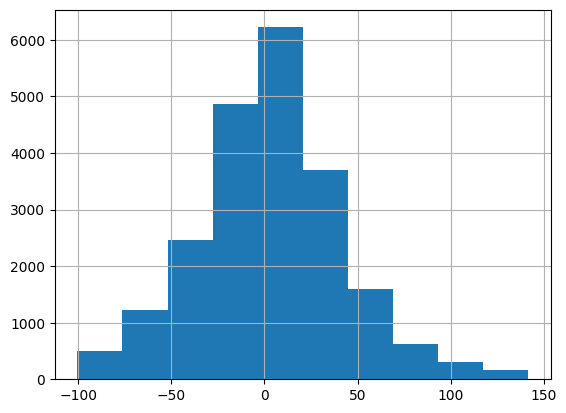

In [23]:
y[y<y.quantile(0.98)].hist()

In [24]:
indx = y < y.quantile(0.98)

In [25]:
# Only using the 98% of original data since y has a long tail
X_train, X_test, y_train, y_test = train_test_split(X[indx], y[indx], 
                                                    test_size=0.2, shuffle=True, random_state=123)

### Simple Linear Regression

In [26]:
y_test.describe()

count   4327.0000
mean       3.5837
std       39.0724
min      -99.9512
25%      -20.3958
50%        3.2790
75%       24.8248
max      141.6989
Name: price_var_next_yr_%, dtype: float64

In [29]:
y_train.describe()

count   17308.0000
mean        3.3708
std        38.8718
min      -100.3972
25%       -20.1050
50%         3.2290
75%        25.9774
max       141.6667
Name: price_var_next_yr_%, dtype: float64

In [32]:
# n_neighbors=1 to impute with uncertainty
# Need to scale for linear regression
lr = Pipeline([('imputer', KNNImputer(n_neighbors=1)),
               ('scaler', StandardScaler()),
               ('model', LinearRegression())])

lr.fit(X_train, y_train)
y_test_lr_pred = lr.predict(X_test)
y_test_lr_pred = np.clip(y_test_lr_pred, -150, 150)  # Since max of y_test and y_train are both under 150
lr_r2 = r2_score(y_test, y_test_lr_pred)
print(f"R^2 score of baseline simple linear regression: {lr_r2:.4f}")

R^2 score of baseline simple linear regression: 0.1371


### Ridge Regression

In [34]:
# n_neighbors=1 to impute with uncertainty
# Need to scale for ridge regression
ridge = Pipeline([('imputer', KNNImputer(n_neighbors=1)),
                  ('scaler', StandardScaler()),
                  ('model', Ridge(alpha=1.0))])

ridge.fit(X_train, y_train)
y_test_ridge_pred = ridge.predict(X_test)
y_test_ridge_pred = np.clip(y_test_ridge_pred, -150, 150)
ridge_r2 = r2_score(y_test, y_test_ridge_pred)
print(f"R^2 score of baseline Ridge regression: {ridge_r2:.4f}")

R^2 score of baseline Ridge regression: 0.1376


### Lasso Regression

In [35]:
# n_neighbors=1 to impute with uncertainty
# Need to scale for lasso regression
lasso = Pipeline([('imputer', KNNImputer(n_neighbors=1)),
                  ('scaler', StandardScaler()),
                  ('model', Lasso(alpha=1.0))])

lasso.fit(X_train, y_train)
y_test_lasso_pred = lasso.predict(X_test)
y_test_lasso_pred = np.clip(y_test_lasso_pred, -150, 150)
lasso_r2 = r2_score(y_test, y_test_lasso_pred)
print(f"R^2 score of baseline Lasso regression: {lasso_r2:.4f}")

R^2 score of baseline Lasso regression: 0.1344


### Random Forest

In [28]:
# n_neighbors=1 to impute with uncertainty
# Don't need to scale for random forest
rf = Pipeline([('imputer', KNNImputer(n_neighbors=1)),
               ('model', RandomForestRegressor(max_depth=12, random_state=123))])

rf.fit(X_train, y_train)
rf_acc = rf.score(X_test, y_test)

print(f"Accuracy of baseline random forest: {rf_acc:.4f}")

Accuracy of baseline random forest: 0.2443
